Found 4059 files belonging to 9 classes.
Found 1019 files belonging to 9 classes.
Clases disponibles: ['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']
Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.2245 - loss: 2.6352 - val_accuracy: 0.3464 - val_loss: 1.7256
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.3400 - loss: 1.7400 - val_accuracy: 0.3876 - val_loss: 1.6083
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.3533 - loss: 1.6928 - val_accuracy: 0.4053 - val_loss: 1.5581
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.3984 - loss: 1.5770 - val_accuracy: 0.4318 - val_loss: 1.5899
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.4231 - loss: 1.5030 - val_accuracy: 0.4612 - val_loss: 1.4255
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.4594 - loss: 1.4562 - val_accuracy: 0.4907 - val_loss: 1.3939
Ep

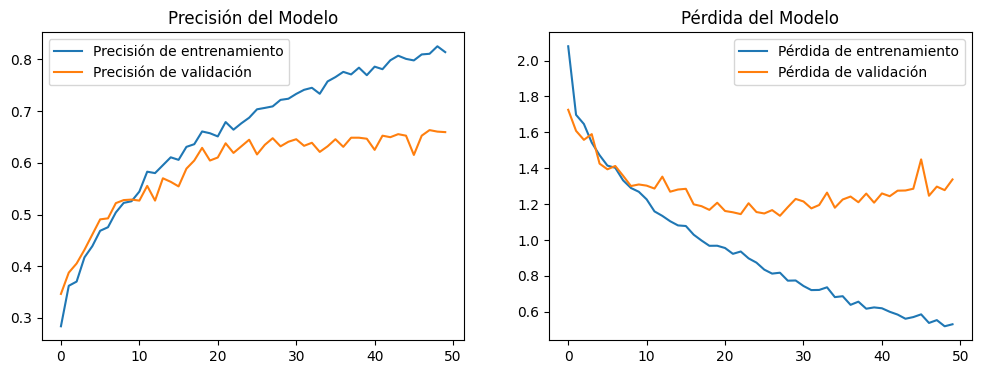

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import shutil

# ruta
dataset_directory = os.path.join(os.getcwd(), 'TrashDataset')


def split_data(dataset_directory, train_size=0.8):namiento y validación (80% entrenamiento, 20% validación)
    classes = os.listdir(dataset_directory)
    if not os.path.exists(os.path.join(dataset_directory, 'train')):
        os.mkdir(os.path.join(dataset_directory, 'train'))
    if not os.path.exists(os.path.join(dataset_directory, 'test')):
        os.mkdir(os.path.join(dataset_directory, 'test'))
    
    for class_name in classes:
        class_path = os.path.join(dataset_directory, class_name)
        if os.path.isdir(class_path):
            
            os.makedirs(os.path.join(dataset_directory, 'train', class_name), exist_ok=True)
            os.makedirs(os.path.join(dataset_directory, 'test', class_name), exist_ok=True)

            
            images = os.listdir(class_path)
            train_images, test_images = train_test_split(images, train_size=train_size, random_state=123)

            
            for image in train_images:
                shutil.move(os.path.join(class_path, image), os.path.join(dataset_directory, 'train', class_name, image))

            for image in test_images:
                shutil.move(os.path.join(class_path, image), os.path.join(dataset_directory, 'test', class_name, image))


split_data(dataset_directory)


train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_directory, 'train'), image_size=(256, 256), batch_size=32, label_mode='int', shuffle=True, seed=123
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_directory, 'test'), image_size=(256, 256), batch_size=32, label_mode='int', shuffle=False, seed=123
)

class_names = train_dataset.class_names
print("Clases disponibles:", class_names)

# Normalización de imágenes
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Aumento de datos
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Definición del modelo
model = models.Sequential([
    layers.Input(shape=(256, 256, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

# Compilación y entrenamiento del modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
epochs = 50
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

# Evaluación del modelo
test_loss, test_acc = model.evaluate(test_dataset)
print("Precisión en test:", test_acc)

# Función para graficar la historia de entrenamiento
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Precisión de entrenamiento')
    plt.plot(epochs_range, val_acc, label='Precisión de validación')
    plt.legend()
    plt.title('Precisión del Modelo')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Pérdida de entrenamiento')
    plt.plot(epochs_range, val_loss, label='Pérdida de validación')
    plt.legend()
    plt.title('Pérdida del Modelo')
    
    plt.show()

plot_history(history)

# Guardado del modelo
model.save('modelo_clasificacion_basuraUltimateN.h5')

# Función de predicción
def predict_image(image_path, model, class_names):
    from tensorflow.keras.preprocessing import image
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    
    print(f'Clase predicha: {class_names[predicted_class]} con confianza del {confidence * 100:.2f}%')
